**Members:** Ethan Wong, Timmy Ren, Mason Shu, Medha Nalamada, Carson Mullen, Bethel Kim

**Morning Cohort**: 11 AM - 1 PM

# Install and Load Libraries

In [21]:
#!pip install eventregistry
#!python -m spacy download en_core_web_lg
#!python -m spacy download en_core_web_sm
from eventregistry import *
import pandas as pd
import json
import re
import spacy # type: ignore
from spacy.matcher import Matcher
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import sklearn
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

# Scraping Articles with Event Registry API

In [6]:
# Load the API key from the JSON file
with open("config.json", "r") as file:
    config = json.load(file)
api_key = config["api_key"]

# Initialize EventRegistry with the API key
er = EventRegistry(apiKey=api_key, allowUseOfArchive=False)

# Define topics to search for
topics = ["Election"]

# Define sources to search for and get their URIs
source_names = source_names = ["NPR", "MSNBC", "AP News", "FOX", "Forbes", "New York Times", "Bloomberg", "USA Today", "Washington Post", "Politico", "Oan", "Breitbart", "Wall Street Journal", "cnn.com"]
source_uris = {source: er.getNewsSourceUri(source) for source in source_names}

# List to store the names of all generated DataFrames
dataframe_names = []

# Loop through each topic
for topic in topics:
    # Get the URI for the concept
    concept_uri = er.getConceptUri(topic)
    
    # List to hold all articles' data for the current topic (across all sources)
    articles_data = []
    
    # Loop through each source individually
    for source_name, source_uri in source_uris.items():
        # Define the query for each topic and source
        q = QueryArticlesIter(
            conceptUri=concept_uri,
            sourceUri=source_uri,
            sourceLocationUri=er.getLocationUri("United States"),  # Only US sources
        )

        # Fetch and accumulate up to 1000 articles for the current topic from this source
        for art in q.execQuery(er, sortBy="date", maxItems=1000):
            articles_data.append({
                "title": art.get("title"),
                "source": art.get("source", {}).get("title"),
                "author": art.get("author"),
                "url": art.get("url"),
                "publishedAt": art.get("dateTime"),
                "content": art.get("body")
            })

    # Create a single DataFrame for the current topic with articles from all sources
    articles_df = pd.DataFrame(articles_data)
    
    # Save the DataFrame to a CSV file
    file_name = f"{topic.replace(' ', '_')}_articles.csv"
    articles_df.to_csv(file_name, index=False)

    # Dynamically set the DataFrame name based on the topic, replacing spaces with underscores
    df_name = f"{topic.replace(' ', '_')}_df"
    globals()[df_name] = articles_df

    # Append the DataFrame name to the list
    dataframe_names.append(df_name)

# Print the list of all generated DataFrame names
print("Generated DataFrames:", dataframe_names)

Generated DataFrames: ['Election_df']


In [7]:
Election_df['source'].value_counts()

source
Fox News                    907
The New York Times          822
AP NEWS                     780
Washington Post             727
POLITICO                    712
USA Today                   507
Breitbart                   506
Forbes                      442
Bloomberg Business          411
MSNBC.com                   259
NPR                         220
One America News Network     88
The Wall Street Journal      46
CNN                          16
Name: count, dtype: int64

# Cleaning Dataframes and Running Name Entity Recognition

In [8]:
# Reading in CSVs dynamically

topics = ["Election"]

# Dictionary to hold the DataFrames after reading them from CSV
dataframes = {}

# Loop to read each CSV and store the DataFrame in the dictionary
for topic in topics:
    # Replace spaces with underscores to match your file naming convention
    file_name = f"{topic.replace(' ', '_')}_articles.csv"
    try:
        dataframes[topic.replace(' ', '_')] = pd.read_csv(file_name)
    except FileNotFoundError as e:
        print(f"Error: {e}")  # If a file is not found

In [9]:
# Clean the dataframes
def count_sentences(text):
    sentences = re.split(r'[.!?]+', text)
    return len([s for s in sentences if s.strip()])

def clean_df(df):
    df = df.drop_duplicates().copy()
    df.loc[:, 'content'] = df['content'].str.replace(
        "By entering your email and pushing continue, you are agreeing to Fox News\' Terms of Use and Privacy Policy, which includes our Notice of Financial Incentive.\n\n", 
        "", 
        regex=False
    )
    df.loc[:, 'num_sentences'] = df['content'].apply(count_sentences)
    return df

# Apply clean_df to each DataFrame in the dictionary
cleaned_dataframes = {key: clean_df(df) for key, df in dataframes.items()}

In [17]:
nlp = spacy.load("en_core_web_lg")

In [ ]:
# Running name entity recognition on the data
nlp = spacy.load("en_core_web_lg")

# Function to extract named entities from a document
def extract_entities_from_docs(docs):
    entity_lists = []
    for doc in docs:
        entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "LOC"] and ent.text.isalpha() and len(ent.text) > 2]
        entity_lists.append(entities)
    return entity_lists

# Loop through all DataFrames
for topic, df in cleaned_dataframes.items():
    print(f"Processing topic: {topic}")
    
    # Filter out rows with missing data in 'title' and 'content'
    df = df.dropna(subset=['title', 'content'])

    # nlp.pipe is btch processing
    title_docs = nlp.pipe(df['title'], disable=["textcat"])
    content_docs = nlp.pipe(df['content'], disable=["textcat"])
    
    df['Title_Entities'] = extract_entities_from_docs(title_docs)
    df['Content_Entities'] = extract_entities_from_docs(content_docs)

    # Combine all entity lists into one for counting
    all_entities = df['Title_Entities'].sum() + df['Content_Entities'].sum()
    
    # Calculate the value counts
    entity_counts = pd.Series(all_entities).value_counts()
    
    # Output the top 10 most frequent entities
    print(f"Top entities for {topic}:\n", entity_counts.head(10))

    # Store the counts for further analysis
    cleaned_dataframes[topic]['Entity_Counts'] = entity_counts

Based on the data, we determined that these were the relevant actors for each topic:

* **Election:** Trump, Harris, Biden

In order to process the articles more efficiently for subsequent steps, we decided to remove any sentences that do not contain the above words. Our reasoning is that now, the articles will be smaller in size while still retaining all of the articles, and that passive/active voice is not getting affected by non-actor sentences.

In [55]:
# Find and replace for each of the sentences
# For article in a given topic, remove any sentences that do not contain these words. 
# Idea is that articles are smaller and easier to process while still retaining the articles 
# Passive/Active voice is not getting affected by non-actor sentences

In [10]:
# Define the keywords and find-and-replace mappings for each topic
topic_keywords = {
    "Election": {
        "keywords": ["Trump", "Harris", "Biden"],
    },
}

# Function to perform find-and-replace operations
def apply_find_replace(text, find_replace_dict):
    # Build a mapping from lowercased keys to their replacements
    lower_find_replace = {k.lower(): v for k, v in find_replace_dict.items()}
    # Escape special characters in keys for regex
    escaped_keys = [re.escape(k) for k in find_replace_dict.keys()]
    pattern = re.compile("|".join(escaped_keys), re.IGNORECASE)
    
    def replace_match(m):
        matched_text = m.group(0)
        # Lookup the replacement using the lowercase matched text
        replacement = lower_find_replace.get(matched_text.lower(), matched_text)
        return replacement
    
    return pattern.sub(replace_match, text)

# Function to filter sentences based on keywords and ensure a keyword threshold is met
def filter_sentences(text, keywords, threshold=1):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split text into sentences
    keyword_pattern = re.compile(r'\b(' + '|'.join(map(re.escape, keywords)) + r')\b', re.IGNORECASE)
    
    filtered_sentences = []
    keyword_count = 0
    
    for sent in sentences:
        if keyword_pattern.search(sent):
            filtered_sentences.append(sent)
            keyword_count += len(keyword_pattern.findall(sent))  # Count occurrences of keywords
    
    # Only return the filtered sentences if the keyword count meets or exceeds the threshold
    if keyword_count >= threshold:
        return ' '.join(filtered_sentences)
    else:
        return ""  # Return empty if the threshold isn't met


In [11]:
# Apply the filtering to each DataFrame
threshold = 3  # Set the threshold for how many keywords need to be found to retain the content

for topic, df in cleaned_dataframes.items():
    print(f"Processing topic: {topic}")
    df = df.copy()
    
    # Get keywords and find-and-replace mappings for the topic
    keywords = topic_keywords.get(topic, {}).get('keywords', [])
    find_replace = topic_keywords.get(topic, {}).get('find_replace', {})
    
    # Apply find-and-replace and sentence filtering to 'content' column
    filtered_contents = []
    for content in df['content']:
        # Skip if content is NaN
        if pd.isnull(content):
            filtered_contents.append(content)
            continue
        
        # Apply find-and-replace operations
        if find_replace:
            content = apply_find_replace(content, find_replace)
        
        # Filter sentences based on keywords and threshold
        filtered_content = filter_sentences(content, keywords, threshold)
        filtered_contents.append(filtered_content)
    
    # Update the DataFrame with the filtered content in the "content" column
    df['content'] = filtered_contents
    cleaned_dataframes[topic] = df

    # Save the updated DataFrame to a new CSV file (optional)
    # df.to_csv(f"{topic.replace(' ', '_')}_filtered_articles.csv", index=False)

Processing topic: Election


In [12]:
# Create a second version of cleaned_dataframes where articles with empty 'content' are removed
cleaned_dataframes_filtered = {}
for topic, df in cleaned_dataframes.items():
    # Remove rows where 'content' is empty or contains only whitespace
    df_filtered = df[df['content'].str.strip().astype(bool)].copy()
    cleaned_dataframes_filtered[topic] = df_filtered

    # Save the filtered DataFrame to a new CSV file (second version)
    # df_filtered.to_csv(f"{topic.replace(' ', '_')}_filtered_articles_no_empty.csv", index=False)

# Print the number of articles before and after filtering
for topic in topic_keywords.keys():
    original_count = len(cleaned_dataframes[topic])
    filtered_count = len(cleaned_dataframes_filtered[topic])
    print(f"Topic: {topic}, Original Articles: {original_count}, After Filtering: {filtered_count}")


Topic: Election, Original Articles: 6443, After Filtering: 4228


In [13]:
cleaned_dataframes_filtered['Election']['content'][5]

'This presidential campaign, former President Donald Trump and other Republicans have been repeating the false narrative that Democrats are purposefully letting migrants into the country so they will vote. Nevertheless, Trump seized on and distorted Richman\'s estimates to fuel false claims in 2016 that millions of noncitizens had illegally voted. One false narrative this campaign season suggests that the people who arrived at the U.S.-Mexico border during the Biden administration can quickly become citizens and vote legally. Furthermore, changes to asylum protocols during the Biden administration have made it harder to pursue asylum in this country and eventually become a citizen. By focusing on baseless allegations about noncitizens voting in the upcoming election, Trump and his allies appear to be laying the groundwork for potentially contesting the election. "You can absolutely bet if Trump loses, he will claim there was widespread noncitizen voting without any evidence whatsoever,

# Performing Bias Analysis

In [14]:
df = cleaned_dataframes_filtered['Election']

In [15]:
df['source'].value_counts()

source
Fox News                    755
Washington Post             565
POLITICO                    555
The New York Times          530
USA Today                   391
Breitbart                   375
AP NEWS                     344
Forbes                      232
MSNBC.com                   222
NPR                         124
One America News Network     61
Bloomberg Business           54
The Wall Street Journal      10
CNN                          10
Name: count, dtype: int64

In [32]:
df[df['source'] == 'CNN']['title']

6427    Press freedom group warns a Trump victory coul...
6430    Five weeks to Election Day, pre-election votin...
6431    Democrats aim to show a judge how pro-Trump Ge...
6432    Biden celebrates Jimmy Carter's 100th birthday...
6433    What to watch for during the Vance-Walz VP debate
6434    Analysis: Why America is looking increasingly ...
6435    Jimmy Carter is setting a new record for Ameri...
6437    In razor-thin Georgia, Harris campaign eyeing ...
6438    Fact check: 12 election lies Trump is using to...
6440    Migrant crossings at the US' southern border d...
Name: title, dtype: object

In [18]:
sia = SentimentIntensityAnalyzer()

# Assume 'df' is your DataFrame with columns: title, source, content, num_sentences

# Define the main actors
actors = ['Trump', 'Harris', 'Biden']

# Initialize the Matcher with the shared vocabulary
matcher = Matcher(nlp.vocab)

# Define the passive voice pattern
passive_rule = [
    {'DEP': 'nsubjpass'},    # Passive nominal subject
    {'DEP': 'aux', 'OP': '*'},   # Optional auxiliary verbs
    {'DEP': 'auxpass'},      # Passive auxiliary
    {'TAG': 'VBN'}           # Past participle verb
]
matcher.add('Passive', [passive_rule])

# Function to detect passive voice using Matcher
def is_passive(doc):
    matches = matcher(doc)
    return bool(matches)

# Batch processing function to handle multiple articles at once
def process_batch(batch_df):
    actor_scores_batch = {}

    # Filter out rows where 'title' or 'content' is missing or empty
    batch_df_filtered = batch_df.dropna(subset=['title', 'content']).copy()
    batch_df_filtered = batch_df_filtered[batch_df_filtered['title'].str.strip() != ""]
    batch_df_filtered = batch_df_filtered[batch_df_filtered['content'].str.strip() != ""]
    
    # Ensure filtered DataFrame is reindexed to avoid index mismatch
    batch_df_filtered.reset_index(drop=True, inplace=True)

    # Process titles and contents together for each article in the batch
    docs_titles = list(nlp.pipe(batch_df_filtered['title'].tolist(), batch_size=batch_size))
    docs_contents = list(nlp.pipe(batch_df_filtered['content'].tolist(), batch_size=batch_size))

    # Process each article in the filtered batch
    for idx, row in batch_df_filtered.iterrows():
        title_doc = docs_titles[idx]
        content_doc = docs_contents[idx]
        source = row['source']
        
        # Initialize actor score dictionary for the source if not present
        if source not in actor_scores_batch:
            actor_scores_batch[source] = {actor: {'title_scores': [], 'content_scores': []} for actor in actors}

        # Function to process sentences (for both content and title)
        def process_sentences(sentences, score_type):
            relevant_sentences = []
            for sentence in sentences:
                if any(actor in sentence.text for actor in actors):
                    relevant_sentences.append(sentence)

            # Process each relevant sentence
            for sentence in relevant_sentences:
                for actor in actors:
                    if actor in sentence.text:
                        # Determine voice score
                        voice_score = -1 if is_passive(sentence) else 1

                        # Determine sentiment score using VADER
                        sentiment_scores = sia.polarity_scores(sentence.text)
                        sentiment = sentiment_scores['compound']  # Compound score between -1 and 1

                        # Multiply voice and sentiment scores
                        score = voice_score * sentiment

                        # Append the score to the actor's list for the source
                        actor_scores_batch[source][actor][score_type].append(score)
        
        # Process title and content sentences in batch
        process_sentences(title_doc.sents, 'title_scores')
        process_sentences(content_doc.sents, 'content_scores')

    return actor_scores_batch

# Batch-level processing setup
batch_size = 100  # Define the batch size
actor_scores_per_source = {}

# Process the DataFrame in batches
for start in range(0, len(df), batch_size):
    batch_df = df.iloc[start:start + batch_size]
    
    # Process each batch
    batch_actor_scores = process_batch(batch_df)
    
    # Merge the batch scores with the overall actor scores
    for source, actor_scores in batch_actor_scores.items():
        if source not in actor_scores_per_source:
            actor_scores_per_source[source] = actor_scores
        else:
            for actor in actors:
                actor_scores_per_source[source][actor]['title_scores'].extend(actor_scores[actor]['title_scores'])
                actor_scores_per_source[source][actor]['content_scores'].extend(actor_scores[actor]['content_scores'])

# Create a list to store the data for DataFrame
average_actor_scores_list = []

# Calculate average scores for each actor per source
for source, actor_scores in actor_scores_per_source.items():
    for actor, scores in actor_scores.items():
        avg_title_score = sum(scores['title_scores']) / len(scores['title_scores']) if scores['title_scores'] else 0
        avg_content_score = sum(scores['content_scores']) / len(scores['content_scores']) if scores['content_scores'] else 0
        
        # Append a row to the list
        average_actor_scores_list.append({
            'source': source,
            'actor': actor,
            'average_title_score': avg_title_score,
            'average_content_score': avg_content_score
        })

# Convert the list into a DataFrame
average_actor_scores_df = pd.DataFrame(average_actor_scores_list)


In [19]:
average_actor_scores_df

,source,actor,average_title_score,average_content_score
0,NPR,Trump,-0.092126,0.036158
1,NPR,Harris,0.002848,0.092787
2,NPR,Biden,-0.226667,0.008695
3,MSNBC.com,Trump,-0.180036,0.000232
4,MSNBC.com,Harris,0.029657,0.105629
5,MSNBC.com,Biden,0.197333,0.024384
6,AP NEWS,Trump,-0.120420,0.028172
7,AP NEWS,Harris,-0.041209,0.091611
8,AP NEWS,Biden,-0.109225,0.030162
9,Fox News,Trump,-0.017919,0.017252


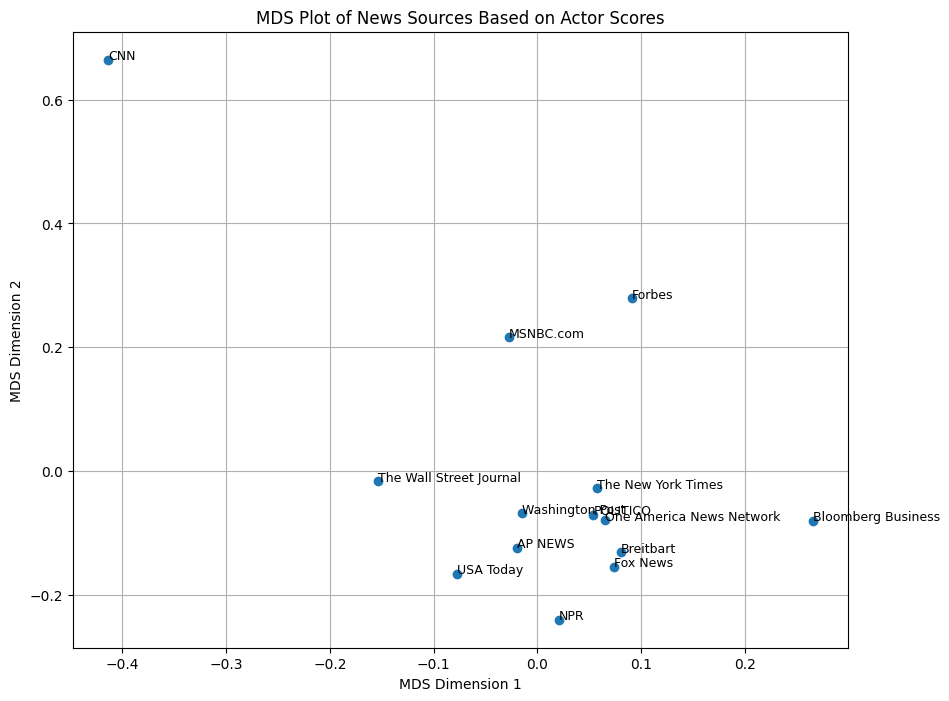

In [22]:
# First, we need to pivot the data to have a row per source and columns for each actor's average scores
pivot_df = average_actor_scores_df.pivot_table(index='source', columns='actor', values=['average_title_score', 'average_content_score'])

# Flatten the MultiIndex columns to simple names
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

# Fill any missing values with 0
pivot_df = pivot_df.fillna(0)

# Compute a distance matrix (Euclidean distance between sources based on their actor scores)
distance_matrix = euclidean_distances(pivot_df)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(distance_matrix)


plt.figure(figsize=(10, 8))
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate each point with its news source
for i, source in enumerate(pivot_df.index):
    plt.text(mds_result[i, 0], mds_result[i, 1], source, fontsize=9)

plt.title('MDS Plot of News Sources Based on Actor Scores')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()
